In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, glob,warnings, glob
from scipy.stats import *
from itertools import combinations
from astropy.io import fits
import pickle
import seaborn as sns
import healpy as hp

ModuleNotFoundError: No module named 'healpy'

In [2]:
data_file = glob.glob('./data_file/*')

In [3]:
maf = {}
for db in data_file:
    dumb= np.load(db)
    dumb.allow_pickle = True
    maf[db]= dumb['metricValues'][np.where(dumb['mask']==False)]

In [4]:
dist_file = glob.glob('./dist_file/*')

In [5]:
dist = {}
for db in dist_file:
    print(db)
    dumb= np.load(db)
    dumb.allow_pickle = True
    dist[db]= dumb['metricValues'][np.where(dumb['mask']==False)]  

./dist_file/_sims_maf_fbs_2_0_vary_nes_vary_nes_nesfrac1_00_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_HEAL.npz
./dist_file/_sims_maf_fbs_2_0_vary_expt_vary_expt_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_HEAL.npz
./dist_file/_sims_maf_fbs_2_0_baseline_baseline_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_HEAL.npz


In [6]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=3.0,extra=0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = (np.sqrt(cov[0, 0])+extra)/2 * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = (np.sqrt(cov[1, 1]) +extra)/2* n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [ ]:
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

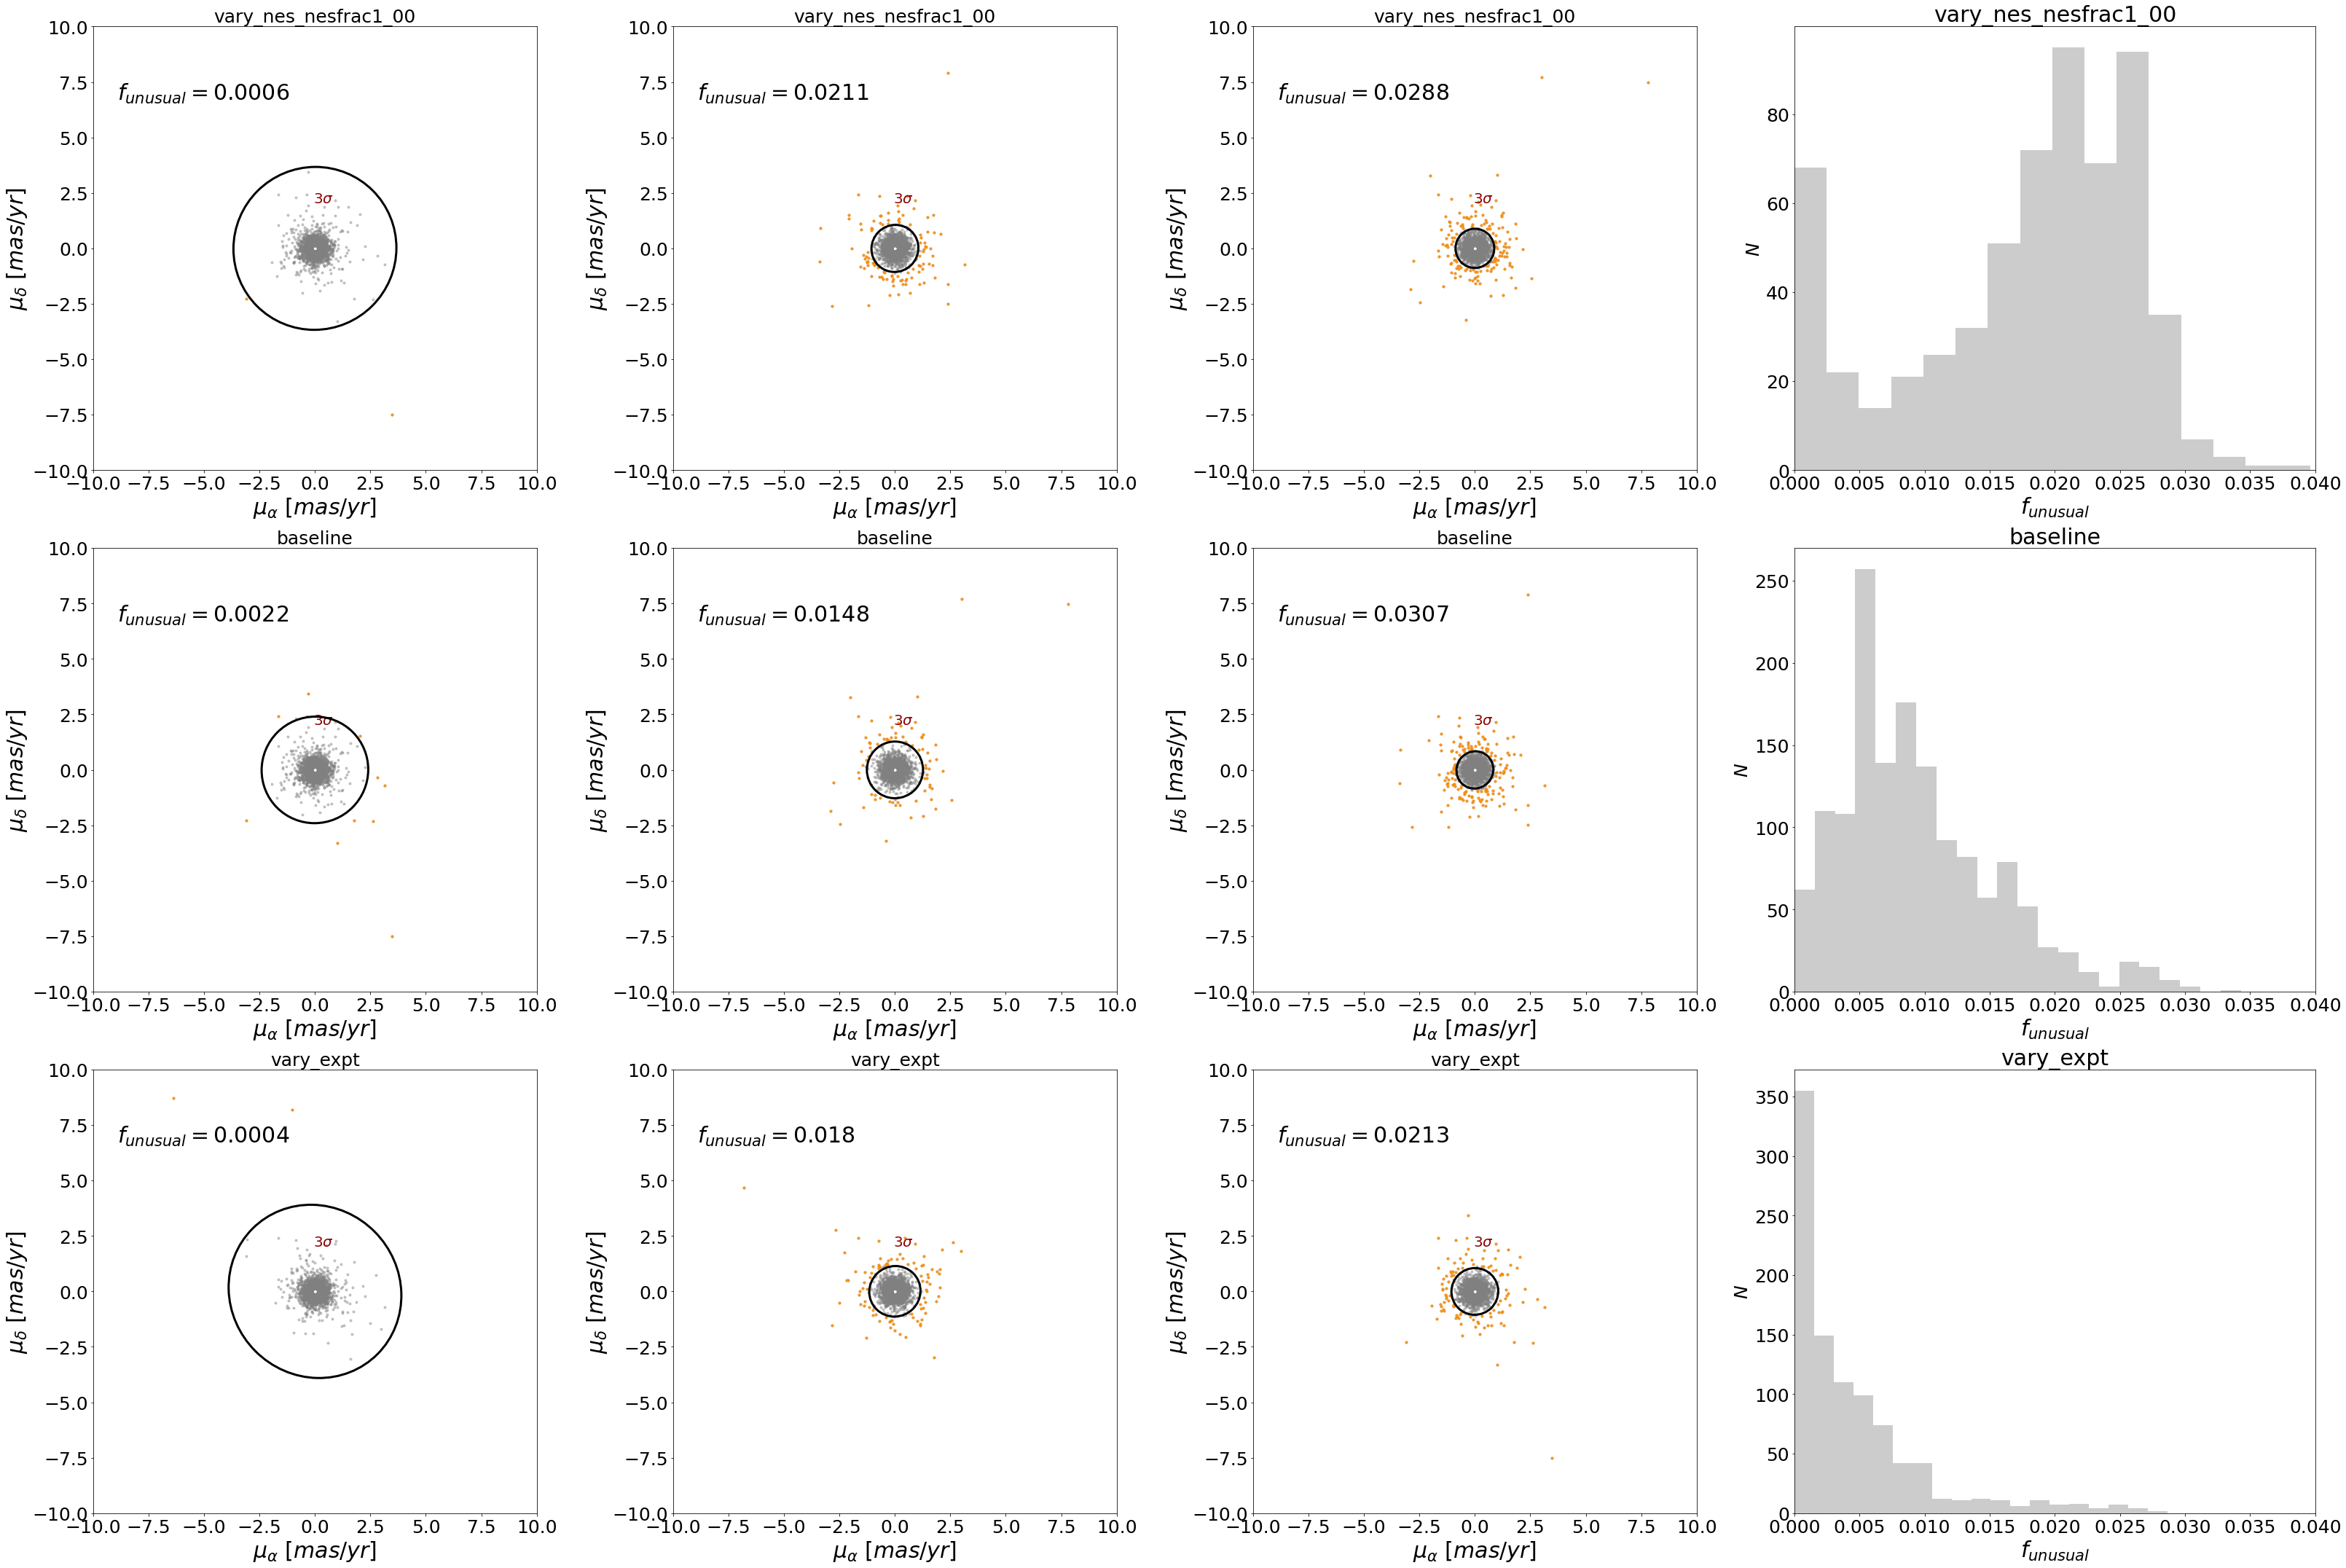

In [11]:
fig, axs= plt.subplots(3,4,figsize=(45,30))
for j,(d,t) in enumerate(zip([ './data_file/_sims_maf_fbs_2_0_vary_nes_vary_nes_nesfrac1_00_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_USER.npz',
'./data_file/_sims_maf_fbs_2_0_baseline_baseline_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_USER.npz',
'./data_file/_sims_maf_fbs_2_0_vary_expt_vary_expt_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_USER.npz'],
                               ['vary_nes_nesfrac1_00','baseline','vary_expt'])):
    
    for i in [0,1,2]:
        axs[j,i].set(adjustable='box', aspect=1)
        if t =='vary_nes_nesfrac1_00' and i==0:
            m = maf[d][1]
        if t =='vary_nes_nesfrac1_00' and i==1:
            m = maf[d][17]
        if t =='vary_nes_nesfrac1_00' and i==2:
            m = maf[d][64]
        if t =='baseline' and i==0:
            m = maf[d][-1]
        if t =='baseline' and i==1:
            m = maf[d][55]
        if t =='baseline' and i==2:
            m = maf[d][10]
        if t =='vary_expt' and i==0:
            m = maf[d][2]
        if t =='vary_expt' and i==1:
            m = maf[d][1]
        if t =='vary_expt' and i==2:
            m = maf[d][4]
        pm = m['PM']*10**3
        pm_un = m['PM_un']*10**3
        pm_un_det = m['PM_un_det']*10**3
        pix = m['pixID']
        det = m['detected']
        sigma = m['sigma']
        #print(np.size(pm))
        #n_in = np.size(pm.pm_alpha)
        contour = confidence_ellipse(pm.pm_alpha, pm.pm_delta,n_std=3.0, extra=sigma,ax=axs[j,i],label=r'$3\sigma$', 
                                     edgecolor='black', linestyle='-', linewidth=3, zorder=100)
        
        points=axs[j,i].transData.transform(np.array([pm_un.pm_alpha, pm_un.pm_delta]).T)
        id_p = contour.contains_points(points)
        
        #n_out = np.size(pm_un.pm_alpha[id_p])
        #print(np.sum(id_p))
        #ax.plot(p_[:,0],p_[:,1],'-',color='black',lw=2)
        axs[j,i].scatter(pm_un.pm_alpha,pm_un.pm_delta,marker='h',s=11, color='grey',alpha =0.4)
        axs[j,i].scatter(pm_un_det.pm_alpha,pm_un_det.pm_delta,marker='h',s=12, color='darkorange',alpha=0.7)
        axs[j,i].text(-.07,2.05,r'$3\sigma$',  weight='bold', fontsize=20,color='darkred')
        #axs[j,i].text(-.07,0.03,r'$1\sigma$', weight='bold',fontsize=20,color='darkred',zorder=100)
        axs[j,i].set_xlim([-10,10])
        axs[j,i].set_ylim([-10,10])
        axs[j,i].set_xlabel(r'$\mu_{\alpha}$ '+r'$[mas/yr]$',fontsize=30)
        axs[j,i].set_ylabel(r'$\mu_{\delta}$ '+r'$[mas/yr]$',fontsize=30)
        axs[j,i].set_title('{}'.format(t), fontsize=25)
        RA,DEC= pix2radec(16,pix)
        axs[j,i].tick_params('both', labelsize=25)
        axs[j,i].annotate('RA={}\nDEC={}'.format(np.round(RA,2),np.round(DEC,2)),
                  (3.,6.75),fontsize=30,fontweight=3)
        axs[j,i].annotate(r'$f_{unusual}= $'+r'${}$'.format(np.round(det,4)),
                  (-8.9,6.7),fontsize=30,fontweight=3)
    if j==0:
        l = 0
    elif j==1:
        l=2
    else:
        l=1
    sns.distplot(dist[dist_file[l]][np.isfinite(dist[dist_file[l]])], ax=axs[j,3], 
                bins=int(2*np.power(np.size(dist[dist_file[l]][np.isfinite(dist[dist_file[l]])]),1/3.)),
                hist=True, kde=False, rug=False, fit=None, hist_kws={'alpha':0.4,'lw':3,'color':'grey'}, )
    axs[j,3].set_title('{}'.format(t), fontsize=30)
    axs[j,3].set_xlabel(r'$f_{unusual}$',fontsize=30)
    axs[j,3].set_ylabel(r'$N$',fontsize=25)
    axs[j,3].set_xlim([0,0.04])
    axs[j,3].tick_params('both', labelsize=25)
    #axs[j,3].set_ylim([0,150])
    #axs[j,3].set_aspect(aspect='equal',adjustable='box')
plt.tight_layout()
plt.savefig('contour_plot.png')